In [38]:
import seaborn as sns
import pandas as pd
import numpyro
import numpyro.distributions as dist
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:
numpyro.set_host_device_count(4)

In [2]:
flights = sns.load_dataset("flights")
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [5]:
flights['month'].cat.codes

0       0
1       1
2       2
3       3
4       4
       ..
139     7
140     8
141     9
142    10
143    11
Length: 144, dtype: int8

In [9]:
flights['time'] = flights['month'].astype(str) + ' ' + flights['year'].astype(str)

In [15]:
flights['time'] = pd.to_datetime(flights['time'], format='%b %Y')

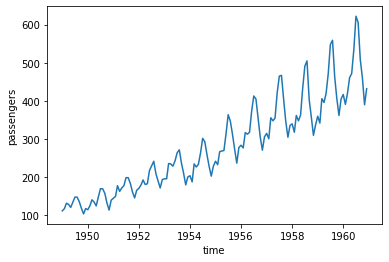

In [16]:
sns.lineplot(data=flights, x='time', y='passengers')

# AR1 -  Very Simple Model

AR1 uses just one data point e.g. use $y_{t-1}$ only for predicting $y_t$

$y_t = A * y_{t-1} + C$

In [20]:
flights = flights.sort_values('time')

In [24]:
flights['passengers_1'] = flights.shift(1)['passengers']

In [25]:
flights

,year,month,passengers,time,passengers_1
0,1949,Jan,112,1949-01-01,NaN
1,1949,Feb,118,1949-02-01,112.0
2,1949,Mar,132,1949-03-01,118.0
3,1949,Apr,129,1949-04-01,132.0
4,1949,May,121,1949-05-01,129.0
...,...,...,...,...,...
139,1960,Aug,606,1960-08-01,622.0
140,1960,Sep,508,1960-09-01,606.0
141,1960,Oct,461,1960-10-01,508.0
142,1960,Nov,390,1960-11-01,461.0


In [33]:
def ar1(y, y_1):
    sigma = numpyro.sample('sigma', dist.HalfNormal(1))
    C = numpyro.sample('C', dist.Normal(0, 1))
    A = numpyro.sample('A', dist.Normal(0, 1))    
    mu = C + A * y_1
    
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=y)

Make the data stationary, and hence easier to model

In [30]:
flights['y'] = flights['passengers'] / flights['passengers_1']
flights['y_1'] = flights['y'].shift(1)

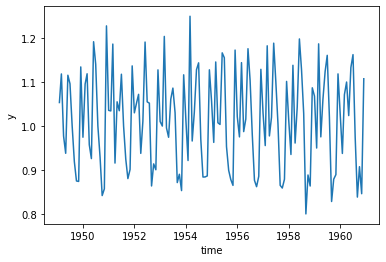

In [29]:
sns.lineplot(data=flights, x='time', y='y')

In [31]:
flights

,year,month,passengers,time,passengers_1,y,y_1
0,1949,Jan,112,1949-01-01,NaN,NaN,NaN
1,1949,Feb,118,1949-02-01,112.0,1.053571,NaN
2,1949,Mar,132,1949-03-01,118.0,1.118644,1.053571
3,1949,Apr,129,1949-04-01,132.0,0.977273,1.118644
4,1949,May,121,1949-05-01,129.0,0.937984,0.977273
...,...,...,...,...,...,...,...
139,1960,Aug,606,1960-08-01,622.0,0.974277,1.162617
140,1960,Sep,508,1960-09-01,606.0,0.838284,0.974277
141,1960,Oct,461,1960-10-01,508.0,0.907480,0.838284
142,1960,Nov,390,1960-11-01,461.0,0.845987,0.907480


In [35]:
data = flights.iloc[2:]

In [36]:
prior_pred = numpyro.infer.Predictive(ar1, num_samples=100)
prior_samples = prior_pred(jax.random.PRNGKey(34), y_1 = data['y_1'].to_numpy(), y=None)

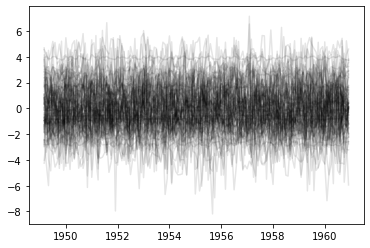

In [41]:
fig, ax = plt.subplots()
ax.plot(data['time'], prior_samples['obs'].T,  color='black', alpha=.1);

In [43]:
sampler = numpyro.infer.NUTS(ar1)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_warmup=1000, num_samples=1000)
mcmc.run(jax.random.PRNGKey(42), y_1 = data['y_1'].to_numpy(), y= data['y'].to_numpy())

/Users/doyoungkim/poetry_files/virtualenvs/goustav-XjPmRQdM-py3.8/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3990.00it/s, 31 steps of size 9.06e-02. acc. prob=0.91]


In [45]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.17      0.09      0.17      0.04      0.32   1064.55      1.00
         C      0.84      0.09      0.84      0.70      0.99   1052.56      1.00
     sigma      0.11      0.01      0.11      0.10      0.12   1617.81      1.00

Number of divergences: 0


We want to check that divergences = 0 and that r_hat is around 1.

Divergences mean posterior samples are unreliable

In [47]:
!pip install arviz

  Using cached arviz-0.11.4-py3-none-any.whl (1.6 MB)
     |████████████████████████████████| 835 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.2 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.4 MB 5.8 MB/s eta 0:00:01    |████████████████▋               | 5.9 MB 3.1 MB/s eta 0:00:02     |████████████████████████████████| 11.4 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 213 kB 7.2 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      Successfully uninstalled pandas-1.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
menuoptimiser 0.0.6 requires personalised-variety@ git+ssh://git@github.com/Gousto/personalisedvariety-image.git@0.0.11#subdirectory=src, which is not installed.
goustav 0.0.6 requires personalised-variety@ git+s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139b08370>,
      dtype=object)

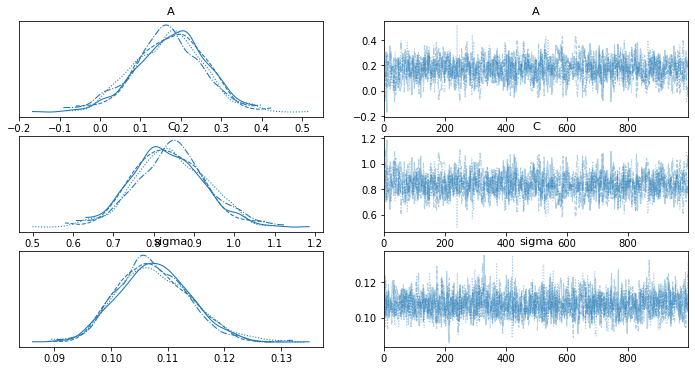

In [48]:
import arviz as az
az.plot_trace(az.from_numpyro(mcmc))

In [49]:
mcmc.get_samples()

{'A': DeviceArray([ 0.18207383,  0.19940242,  0.23186475, ...,  0.03556702,
              -0.03490384,  0.01532605], dtype=float32),
 'C': DeviceArray([0.81245816, 0.8206418 , 0.76423967, ..., 0.9610049 ,
              1.0603234 , 0.99103576], dtype=float32),
 'sigma': DeviceArray([0.11415828, 0.1136256 , 0.10551682, ..., 0.10373798,
              0.11645024, 0.13080546], dtype=float32)}

In [50]:
post_pred = numpyro.infer.Predictive(ar1, mcmc.get_samples())
post_samples = post_pred(jax.random.PRNGKey(52), y_1 = data['y_1'].to_numpy(), y=None)

In [52]:
post_samples['obs'].shape

(4000, 142)

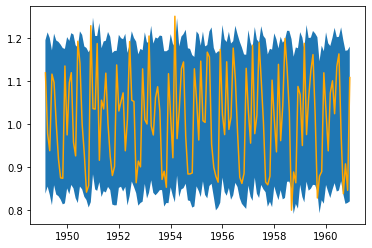

In [54]:
fig, ax = plt.subplots()
ax.fill_between(data['time'], *numpyro.diagnostics.hpdi(post_samples['obs']));
ax.plot(data['time'], data['y'], color='orange')

## ARMA(1,1) 
ARMA(1,1) contains 1 previous term and 1 error term.
i.e. 

$y_t = C + A*y_{t-1} + B*err_{t-1}$
where

$err_{t-1} = y_{t-1} - \hat{y}_{t-1}$

The incorporation of the error term means we would need a for loop, which is slow in Python.

Can use jax.lax.scan to make this fast (this essentially translates the for loop to a lower level language, so that it executes faster).

1. rewrite current model with for loop
2. incorporate error term
3. jax.lax.scan

In [62]:
# First define AR1 using for loop.
def ar1_forloop(y):
    sigma = numpyro.sample('sigma', dist.HalfNormal(1))
    C = numpyro.sample('C', dist.Normal(0, 1))
    A = numpyro.sample('A', dist.Normal(0, 1))    
    preds = []
    for i in range(1, len(y)):
        preds.append(C + A * y[i-1])
    mu = jnp.asarray(preds)
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=y[1:])
    # Note this is the same as numpyro.factor('factor', dist.Normal(mu, sigma).log_prob(y[1:]))

In [63]:
sampler = numpyro.infer.NUTS(ar1_forloop)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_warmup=1000, num_samples=1000)
mcmc.run(jax.random.PRNGKey(42), y= data['y'].to_numpy())

sample: 100%|█████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1972.08it/s, 63 steps of size 7.23e-02. acc. prob=0.93]


In [64]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.18      0.08      0.17      0.04      0.31   1319.24      1.00
         C      0.84      0.09      0.84      0.69      0.96   1318.19      1.00
     sigma      0.11      0.01      0.11      0.10      0.12   1399.44      1.00

Number of divergences: 0


In [152]:
# Now define ARMA(1,1) model, using for loop.
def arma(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    phi = numpyro.sample(
        'phi',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    logp = 0
    err = [y[0] - (mu + phi*mu)]
    preds = []
    for t in range(1, len(y)):
        err.append(y[t] - (alpha*y[t-1] + phi*err[-1]))
        preds.append(alpha*y[t-1] + phi*err[-1])
    
    numpyro.deterministic('preds', jnp.asarray(preds))
    numpyro.factor(
        'factor',
        numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array(err)),
    )
    

In [109]:
sampler = numpyro.infer.NUTS(arma)
mcmc = numpyro.infer.MCMC(sampler, num_chains=1, num_warmup=1000, num_samples=1000)
mcmc.run(jax.random.PRNGKey(42), y= data['y'].to_numpy())

sample: 100%|██████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 151.70it/s, 15 steps of size 2.57e-01. acc. prob=0.94]


In [93]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.99      0.01      0.99      0.98      1.00    735.76      1.00
        mu      0.67      0.17      0.68      0.40      0.93    971.55      1.00
       phi      0.51      0.02      0.51      0.47      0.55    796.55      1.00
     sigma      0.08      0.01      0.08      0.07      0.09   1248.24      1.00

Number of divergences: 0


In [110]:
mcmc.get_samples()['preds'].shape

(1000, 141)

In [111]:
mcmc.get_samples()['sigma'].shape

(1000,)

In [123]:
jnp.repeat(mcmc.get_samples()['sigma'][:, jnp.newaxis], 141, axis=1).shape

(1000, 141)

In [127]:
dist.Normal(mcmc.get_samples()['preds'], jnp.repeat(mcmc.get_samples()['sigma'][:, jnp.newaxis], 141, axis=1)).sample(jax.random.PRNGKey(115)).shape

(1000, 141)

In [97]:
post_pred = numpyro.infer.Predictive(arma, mcmc.get_samples())
post_samples = post_pred(jax.random.PRNGKey(60), y = data['y'].to_numpy())

In [102]:
post_samples['obs']

DeviceArray([[0.97727275, 0.93798447, 1.1157025 , ..., 0.9074803 ,
              0.84598696, 1.1076924 ],
             [0.97727275, 0.93798447, 1.1157025 , ..., 0.9074803 ,
              0.84598696, 1.1076924 ],
             [0.97727275, 0.93798447, 1.1157025 , ..., 0.9074803 ,
              0.84598696, 1.1076924 ],
             ...,
             [0.97727275, 0.93798447, 1.1157025 , ..., 0.9074803 ,
              0.84598696, 1.1076924 ],
             [0.97727275, 0.93798447, 1.1157025 , ..., 0.9074803 ,
              0.84598696, 1.1076924 ],
             [0.97727275, 0.93798447, 1.1157025 , ..., 0.9074803 ,
              0.84598696, 1.1076924 ]], dtype=float32)

In [129]:
data['time'].iloc[1:]
numpyro.diagnostics.hpdi(dist.Normal(mcmc.get_samples()['preds'], jnp.repeat(mcmc.get_samples()['sigma'][:, jnp.newaxis], 141, axis=1)).sample(jax.random.PRNGKey(115)))

array([[0.9251177 , 0.79687095, 0.63005763, 0.87560725, 0.9184203 ,
        0.8622886 , 0.7770136 , 0.71946526, 0.5464685 , 0.9460018 ,
        0.68274236, 0.8111621 , 0.95760643, 0.7874416 , 0.57802856,
        0.9435731 , 0.9676035 , 0.88526905, 0.8107792 , 0.70369625,
        0.44869542, 1.0372564 , 0.8295115 , 0.70407766, 1.0968902 ,
        0.66944134, 0.8168656 , 0.758322  , 0.964308  , 0.8369999 ,
        0.7581828 , 0.7024974 , 0.56277126, 0.9145439 , 0.8115947 ,
        0.8062542 , 0.9083785 , 0.71504813, 0.6798142 , 0.9944334 ,
        0.8750082 , 0.9650208 , 0.71428025, 0.7308647 , 0.58750683,
        0.9370446 , 0.80661494, 0.65971327, 1.0208437 , 0.8492807 ,
        0.7701226 , 0.8275536 , 0.9305185 , 0.91191596, 0.7201725 ,
        0.7364056 , 0.50237507, 0.89050937, 0.86038   , 0.54515773,
        1.1164929 , 0.74903685, 0.774161  , 0.8641075 , 1.0236244 ,
        0.8645884 , 0.7493819 , 0.6971375 , 0.5496576 , 0.88546145,
        0.8926985 , 0.6831254 , 0.95098794, 0.82

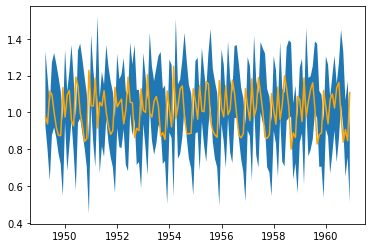

In [132]:
fig, ax = plt.subplots()

ax.fill_between(data['time'].iloc[1:], *numpyro.diagnostics.hpdi(dist.Normal(mcmc.get_samples()['preds'], jnp.repeat(mcmc.get_samples()['sigma'][:, jnp.newaxis], 141, axis=1)).sample(jax.random.PRNGKey(115))));

#ax.plot(data['time'].iloc[1:], mcmc.get_samples()['preds'].mean(axis=0), color='orange')
ax.plot(data['time'].iloc[1:], data['y'].iloc[1:], color='orange')

## Using the flights data doesn't seem to yield amazing results, so try generating data instead.

In [138]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
ar1 = np.array([1, 0.33])
ma1 = np.array([1, 0.9])
simulated_ARMA_data = ArmaProcess(ar1, ma1).generate_sample(nsample=142)

In [135]:
!pip install statsmodels

     |████████████████████████████████| 9.5 MB 13 kB/s  eta 0:00:01
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)
You should consider upgrading via the '/Users/doyoungkim/poetry_files/virtualenvs/goustav-XjPmRQdM-py3.8/bin/python -m pip install --upgrade pip' command.


In [140]:
time = np.arange(len(simulated_ARMA_data))
y = simulated_ARMA_data

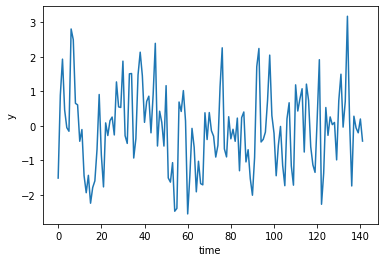

In [142]:
sns.lineplot(data=pd.DataFrame({'time': time, 'y': y}), x='time', y='y')

In [143]:
sampler = numpyro.infer.NUTS(arma)
mcmc = numpyro.infer.MCMC(sampler, num_chains=1, num_warmup=1000, num_samples=1000)
mcmc.run(jax.random.PRNGKey(42), y=y)

sample: 100%|██████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.53it/s, 15 steps of size 4.47e-01. acc. prob=0.92]


In [144]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.28      0.13     -0.28     -0.52     -0.10    381.35      1.00
        mu     -0.36      0.32     -0.34     -0.91      0.09    442.55      1.00
       phi      0.82      0.10      0.84      0.69      0.95    362.41      1.00
     sigma      1.04      0.06      1.04      0.94      1.14    788.83      1.00

Number of divergences: 0


In [145]:
mcmc.get_samples()['preds'].shape

(1000, 141)

In [146]:
mcmc.get_samples()['sigma'].shape

(1000,)

In [147]:
dist.Normal(mcmc.get_samples()['preds'], jnp.repeat(mcmc.get_samples()['sigma'][:, jnp.newaxis], 141, axis=1)).sample(jax.random.PRNGKey(115)).shape

(1000, 141)

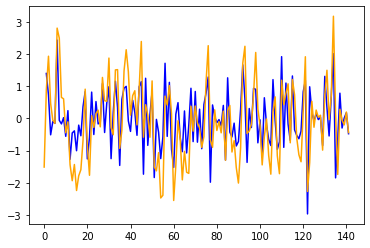

In [151]:
fig, ax = plt.subplots()

#ax.fill_between(time[1:], *numpyro.diagnostics.hpdi(dist.Normal(mcmc.get_samples()['preds'], jnp.repeat(mcmc.get_samples()['sigma'][:, jnp.newaxis], 141, axis=1)).sample(jax.random.PRNGKey(115))));

ax.plot(time[1:], mcmc.get_samples()['preds'].mean(axis=0), color='blue')
ax.plot(time,y, color='orange')